In [1]:
from __future__ import print_function   # Python 2/3 compatability

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import spatial

## Tesselations

There are a number of ways to carve up a 2D plane. Two common ways are through Voronoi or Delaunay tesselation. Delaunay is commonly used in interpolation, which is more involved. Let's look at Voronoi tesselation first.

### Voronoi diagrams

Given a number of points, a [Voronoi diagram](https://en.wikipedia.org/wiki/Voronoi_diagram) divides the plane into regions where all the points in a region are closer to a corresponding point than all other points.

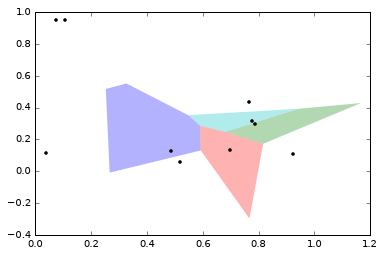

In [38]:
pts = np.random.rand(10, 2)   # some random x-y pairs. Note Voronoi tesselation can be N-dimensional.

vor = spatial.Voronoi(pts)

for indices in vor.regions:
    if not indices: continue     # check for empty regions
    if -1 in indices: continue   # region includes a vertex out of the diagram (the region goes to infinity)
    plt.fill(vor.vertices[indices, 0], vor.vertices[indices, 1], edgecolor='none', alpha=0.3)

plt.plot(pts[:, 0], pts[:, 1], '.k')

### Delaunay triangulation

Given a number of points, [Delaunay triangulation](https://en.wikipedia.org/wiki/Delaunay_triangulation) divides the plane into a series of triangles, using the given points as the verticies of the triangles, such that each triangle does not contain any other points (technically, no points are within the circumcircle).

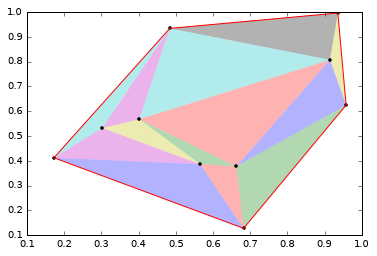

In [50]:
pts = np.random.rand(10, 2)
tri = spatial.Delaunay(pts)

# The individual triangles, colored randomly
for indices in tri.vertices:
    plt.fill(tri.points[indices, 0], tri.points[indices, 1], edgecolor='none', alpha=0.3)

# The original points, the triagnel vertices.
plt.plot(pts[:, 0], pts[:, 1], '.k')

# And, the convex hull that surrounds the region with triangles.
for indices in tri.convex_hull:
    plt.plot(tri.points[indices, 0], tri.points[indices, 1], color='red')


To use traingulation for interpolation, we will functions in the `scipy.interpolate` subpackage. Most of these functions use Delaunay interpolation under the hood. For example, you can pass an existing Triangulation to `scipy.interpolate.LinearNDInterpolator`. However, you can also just pass it the points you want, and it will do the triangulation for you.

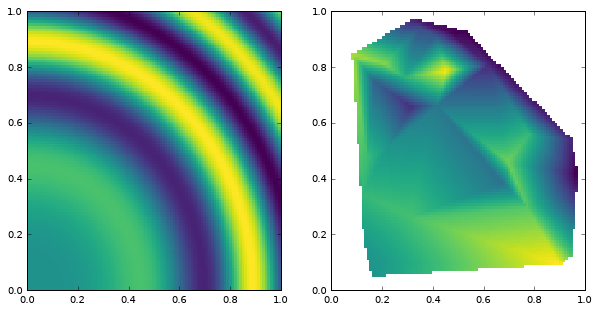

In [101]:
from scipy import interpolate

pts = np.random.rand(30, 2)
tri = spatial.Delaunay(pts)

def calc_z(x, y):
    r2 = x**2 + y**2
    return np.sin(r2*10)*r2*np.exp(-r2)

x = pts[:, 0]
y = pts[:, 1]
z = calc_z(x, y)

# create an iterpolation object. We need to supply the values on the specified xy points.
interp = interpolate.LinearNDInterpolator(tri, z)

ygrid, xgrid = np.mgrid[0:1:100j, 0:1:100j]
zgrid = interp(xgrid, ygrid)

zgrid = np.ma.masked_where(np.isnan(zgrid), zgrid)
zgrid_true = calc_z(xgrid, ygrid)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].pcolormesh(xgrid, ygrid, zgrid_true, cmap='viridis')
axs[1].pcolormesh(xgrid, ygrid, zgrid, cmap='viridis')

But is is generally much easier to just use the `scipy.interpolate.griddata` command, unless you are doing multiple interpolations with different data on the same set of points. The data must be put in the right format first, as this example demonstrates. This convinience function allows you to quickly switch between `nearest`, `linear` and `cubic` interpolation. Note cubic only works for 1- and 2D interpolation.

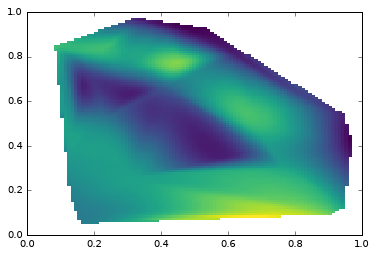

In [102]:
points = np.vstack((x, y)).T
values = z
xi = np.vstack((xgrid.flat, ygrid.flat)).T
zgrid = interpolate.griddata(points, values, xi, method='cubic')

zgrid.shape = xgrid.shape
zgrid = np.ma.masked_where(np.isnan(zgrid), zgrid)

plt.pcolormesh(xgrid, ygrid, zgrid, cmap='viridis')

---
### *Exercise*

> Experiment with different numbers of data points and different methods. What is the minimum number of data points you feel is required for a reasonable interpolation? What is the best method?

---